## IMPORTING LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator #generate labels for the images

from tensorflow.keras import layers, models


In [2]:
batch_size = 10
img_height = 200
img_width = 200

In [3]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
     horizontal_flip=True,
    vertical_flip= True,
    rotation_range=45,
    zoom_range=0.2
)
train_aug_ds = train_datagen.flow_from_directory(
      "C:/dataset/train/",

)

validation_datagen = ImageDataGenerator(
      rescale = 1./255,
     horizontal_flip=True,
    vertical_flip= True,
    rotation_range=45,
    zoom_range=0.2
)

validation_aug_ds = validation_datagen.flow_from_directory(
"C:/dataset/validation/", )

Found 58 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "C:/dataset/train/",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 58 files belonging to 2 classes.


In [5]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
  "C:/dataset/validation/" ,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 10 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['healthy_leaves', 'unhealthy_leaves']


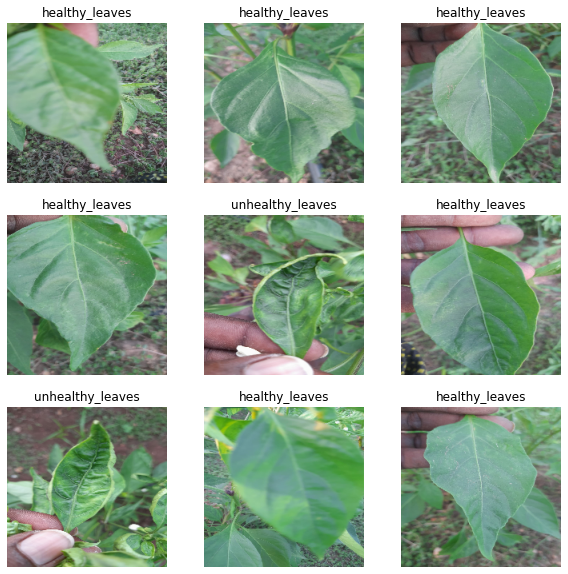

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 200, 200, 3)
(10,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.07178429 0.9607844


### DATA AUGMENTATION

In [12]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1)
])

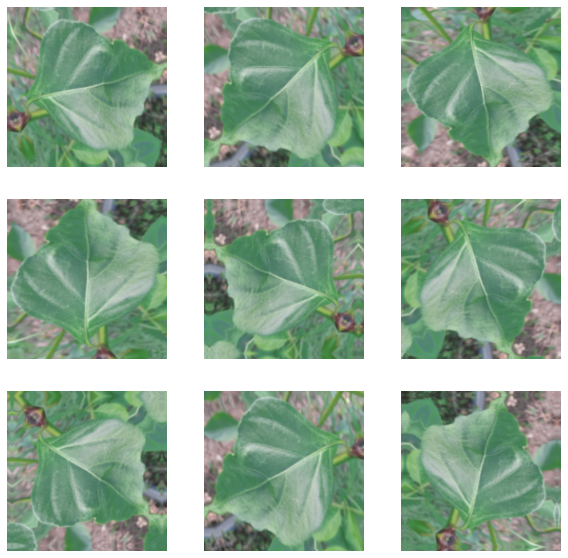

In [13]:
plt.figure(figsize=(10, 10))  #Image after applying data augmentation
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### CNN With DATA AUGMENTATION

In [139]:
num_classes = len(class_names)

model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [140]:
model_2.compile(optimizer='RMSprop',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [141]:
model_2.build(input_shape=(10,200,200,3))
model_2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (10, 200, 200, 3)         0         
                                                                 
 rescaling_11 (Rescaling)    (10, 200, 200, 3)         0         
                                                                 
 conv2d_47 (Conv2D)          (10, 200, 200, 16)        448       
                                                                 
 max_pooling2d_48 (MaxPoolin  (10, 100, 100, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (10, 100, 100, 32)        4640      
                                                                 
 max_pooling2d_49 (MaxPoolin  (10, 50, 50, 32)         0         
 g2D)                                                

In [142]:
epochs=20
history_2 = model_2.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
6/6 [==============================] - 6s 672ms/step - loss: 7.4417 - accuracy: 0.4483 - val_loss: 0.6630 - val_accuracy: 0.6000
Epoch 2/20
6/6 [==============================] - 4s 654ms/step - loss: 0.7535 - accuracy: 0.6034 - val_loss: 0.6484 - val_accuracy: 0.6000
Epoch 3/20
6/6 [==============================] - 4s 680ms/step - loss: 0.6029 - accuracy: 0.6897 - val_loss: 0.8765 - val_accuracy: 0.6000
Epoch 4/20
6/6 [==============================] - 3s 566ms/step - loss: 0.6617 - accuracy: 0.7241 - val_loss: 0.6484 - val_accuracy: 0.6000
Epoch 5/20
6/6 [==============================] - 3s 540ms/step - loss: 0.5843 - accuracy: 0.7759 - val_loss: 0.6473 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 3s 544ms/step - loss: 0.6350 - accuracy: 0.6207 - val_loss: 0.5610 - val_accuracy: 0.6000
Epoch 7/20
6/6 [==============================] - 3s 552ms/step - loss: 0.6109 - accuracy: 0.6724 - val_loss: 0.4734 - val_accuracy: 0.9000
Epoch 8/20
6/6 [====

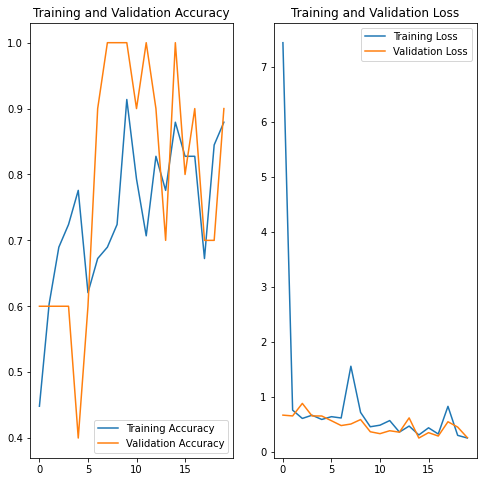

In [145]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [146]:
loss, acc = model_2.evaluate(test_ds, verbose = 2)
print("Accuracy", acc)

2/2 - 0s - loss: 0.4599 - accuracy: 0.8235 - 230ms/epoch - 115ms/step
Accuracy 0.8235294222831726


### TRANSFER LEARNING WITH DATA AUGMENTATION

#### ResNet50V2

In [ ]:
import datetime

In [147]:
# Creating a callback function to save model's metrics
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir= dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
     )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [148]:
# Creating model using Resnet50V2 architecture
tl_model = tf.keras.applications.ResNet50V2(include_top=False)
tl_model.trainable = False
inputs = layers.Input(shape=(200, 200, 3), name='input_layer')
x = tl_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3= tf.keras.Model(inputs, outputs)

In [150]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_41 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [151]:
model_3.compile(optimizer='adam',
loss = 'binary_crossentropy',
              metrics=['accuracy'])
epochs=20
history_3 = model_3.fit(
  train_aug_ds,
  validation_data=validation_aug_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 27s 9s/step - loss: 0.7181 - accuracy: 0.5000 - val_loss: 0.7644 - val_accuracy: 0.5000
Epoch 2/20
2/2 [==============================] - 11s 6s/step - loss: 0.7148 - accuracy: 0.5000 - val_loss: 0.7244 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 11s 6s/step - loss: 0.7186 - accuracy: 0.5000 - val_loss: 0.7146 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 12s 5s/step - loss: 0.7196 - accuracy: 0.5000 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 10s 5s/step - loss: 0.7134 - accuracy: 0.5000 - val_loss: 0.7147 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 11s 6s/step - loss: 0.7127 - accuracy: 0.5000 - val_loss: 0.7220 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 11s 6s/step - loss: 0.7067 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.5000
Epoch 8/20
2/2 [==================

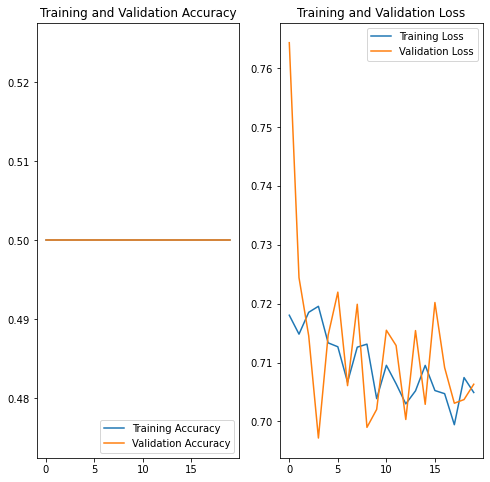

In [157]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [158]:
loss, acc = model_3.evaluate(test_ds, verbose = 2)
print("Accuracy", acc)

2/2 - 2s - loss: 24.0547 - accuracy: 0.5882 - 2s/epoch - 801ms/step
Accuracy 0.5882353186607361


#### AlexNet

In [154]:
#Instantiation
model_4 = Sequential()

#1st Convolutional Layer
model_4.add(Conv2D(filters=96, input_shape=(200,200,3), kernel_size=(11,11), strides=(4,4), padding='same'))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
model_4.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
model_4.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))

#4th Convolutional Layer
model_4.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))

#5th Convolutional Layer
model_4.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
model_4.add(Flatten())
# 1st Fully Connected Layer
model_4.add(Dense(4096, input_shape=(200,200,3,)))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))
# Add Dropout to prevent overfitting
model_4.add(Dropout(0.4))

#2nd Fully Connected Layer
model_4.add(Dense(4096))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('relu'))
#Add Dropout
model_4.add(Dropout(0.4))


#Output Layer
model_4.add(Dense(1))
model_4.add(tf.keras.layers.BatchNormalization())
model_4.add(Activation('sigmoid'))

#Model Summary
model_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 50, 50, 96)        34944     
                                                                 
 batch_normalization_32 (Bat  (None, 50, 50, 96)       384       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 50, 50, 96)        0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 25, 25, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 25, 25, 256)       614656    
                                                                 
 batch_normalization_33 (Bat  (None, 25, 25, 256)    

In [155]:
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [159]:
epochs=20
history_4 = model_4.fit(
  train_aug_ds,
  validation_data= validation__aug_ds,
  epochs=epochs
)

Epoch 1/20
6/6 [==============================] - 15s 2s/step - loss: 0.5348 - accuracy: 0.7931 - val_loss: 787.7797 - val_accuracy: 0.4000
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 0.3929 - accuracy: 0.9655 - val_loss: 928.1735 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 8s 1s/step - loss: 0.3779 - accuracy: 1.0000 - val_loss: 645.6938 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.3751 - accuracy: 1.0000 - val_loss: 392.0014 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 8s 1s/step - loss: 0.3712 - accuracy: 1.0000 - val_loss: 251.5555 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.3691 - accuracy: 1.0000 - val_loss: 165.8725 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.3667 - accuracy: 1.0000 - val_loss: 114.3116 - val_accuracy: 0.4000
Epoch 8/20
6/6 [==========

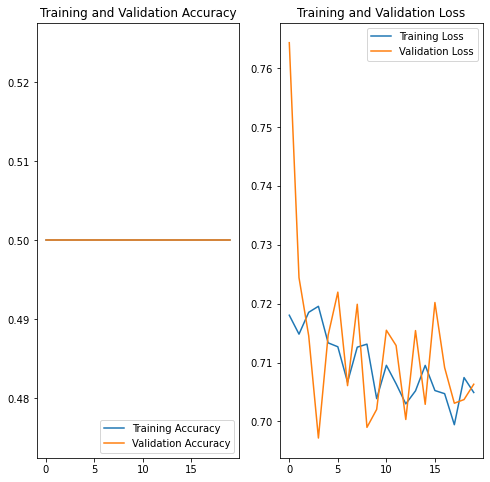

In [160]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [161]:
loss, acc = model_4.evaluate(test_ds, verbose = 2)
print("Accuracy", acc)

2/2 - 1s - loss: 4.2140 - accuracy: 0.4118 - 585ms/epoch - 293ms/step
Accuracy 0.4117647111415863


#### VGG16

In [162]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(200,200,3))
base_model.trainable = False ## Not trainable weights

In [163]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')


model_5 = models.Sequential([
    
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [164]:
model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [166]:
history_5 = model_5.fit(
  train_aug_ds,
  validation_data= validation_aug_ds,
  epochs=epochs
)

Epoch 1/20
6/6 [==============================] - 15s 2s/step - loss: 1.1156 - accuracy: 0.8276 - val_loss: 0.4937 - val_accuracy: 0.9000
Epoch 2/20
6/6 [==============================] - 13s 2s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.6415 - val_accuracy: 0.9000
Epoch 3/20
6/6 [==============================] - 13s 2s/step - loss: 8.5660e-08 - accuracy: 1.0000 - val_loss: 0.7877 - val_accuracy: 0.9000
Epoch 4/20
6/6 [==============================] - 13s 2s/step - loss: 5.9448e-08 - accuracy: 1.0000 - val_loss: 0.8732 - val_accuracy: 0.9000
Epoch 5/20
6/6 [==============================] - 14s 2s/step - loss: 3.4571e-09 - accuracy: 1.0000 - val_loss: 0.9316 - val_accuracy: 0.9000
Epoch 6/20
6/6 [==============================] - 13s 2s/step - loss: 2.5914e-09 - accuracy: 1.0000 - val_loss: 0.9653 - val_accuracy: 0.9000
Epoch 7/20
6/6 [==============================] - 13s 2s/step - loss: 2.0726e-09 - accuracy: 1.0000 - val_loss: 0.9847 - val_accuracy: 0.9000
Epoch 8/20
6/6

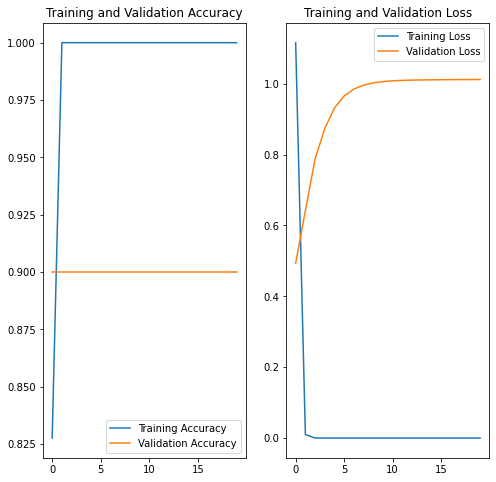

In [169]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [170]:
loss, acc = model_5.evaluate(test_ds, verbose = 2)
print("Accuracy", acc)

2/2 - 3s - loss: 1.5587 - accuracy: 0.8235 - 3s/epoch - 2s/step
Accuracy 0.8235294222831726
